# Exponential Comparisons
step1: pds(emp power)
step2: theoretical exp. dist
step3: compare two distributions

In [1]:
cd ..

C:\Users\Lauren\Voytek\spectralCV


In [2]:
from scv_funcs import access_nt as asc
import numpy as np

In [3]:
data_path ="/Users/Lauren/Data/NeuroTycho/anesthesia/20120730PF_Anesthesia+and+Sleep_Chibi_Toru+Yanagawa_mat_ECoG128/Session%d/"
session = 1
chan = [1,2]

# with specified indices
indices = [0,0]
data = asc.get_ECoG(data_path, session, chan, indices)

In [4]:
import neurodsp as ndsp
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
fs = 1000
nperseg = 1000
noverlap = nperseg/2
f, psd_ = ndsp.spectral.psd(data, Fs=fs, nperseg=nperseg, noverlap=noverlap)
#_, _, spg_ =

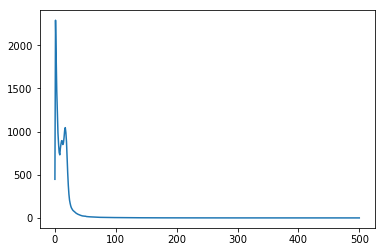

In [6]:
_ = plt.plot(psd_[0])

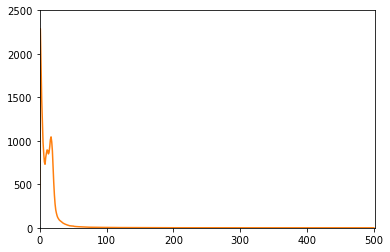

In [6]:
x = np.linspace(0, 500, 500)
#x = np.random.rand(500)*500
y = np.exp(x)
_ = plt.plot(-x,y)
_ = plt.plot(psd_[0])
_= plt.xlim([0,501])
_= plt.ylim([0,2500])

In [33]:
data[0]

array([119, 139, 153, ...,  30,  54,  61], dtype=int16)

In [50]:
sp.stats.expon.fit?

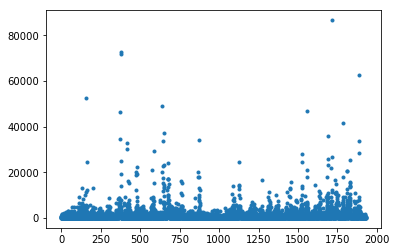

In [32]:
from scipy.stats import expon
import scipy as sp
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)
mean, var, skew, kurt = expon.stats(moments='mvsk')
#x = np.arange(1,50)
#ax.plot(x, expon.pdf(x),'r-', lw=5, alpha=0.6, label='expon pdf')
#_ = ax.plot(psd_[0][:100])
# _ = ax.plot(psd_[1])
x, y, spg_ = sp.signal.spectrogram(data[0],fs=fs,nperseg=nperseg/2,noverlap=noverlap/2)
_, scale_ = sp.stats.expon.fit(spg_[0],floc=0)
#_ = ax.plot(x,scale_*np.exp(-(1/scale_)*x))
#np.exp(scale_*x)
#scale_
# expon.fit()
for i in x
plt.plot(y,spg_[2],'.')
# x

In [18]:
?sp.signal.spectrogram

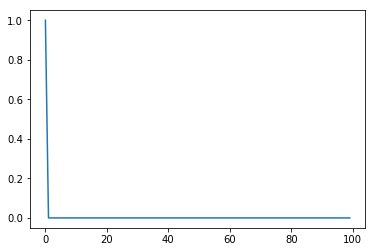

In [48]:
xx=np.arange(100)
lam=200
plt.plot(xx, np.exp(-lam*xx))


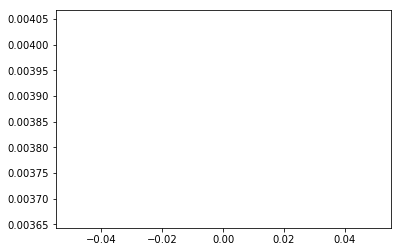

In [24]:
plt.plot((expon.pdf(scale_)))

In [9]:
len(psd_[0]), len(x)

(501, 501)

In [10]:
x;